#### Purpose of this kernel
This kernel wants to take a closer look on Preprcessing. In contrast to the kernels 01-05 here the effect of different preprocessing steps on the Embeddings will be examined.

The kernels 01-05 gave the following insights and raised the following questions:
* Does it make sense to limit the number of words the model is trained with? So far all kernel models only were allowed to use maximum 10k words. Since generally neuronal networks benefit from increasing data volumes this barrier is removed here.

* The maxlen hyperparameter was arbitrary set to 100. Different maxlens shall be examined here.

* As discussed here: https://www.kaggle.com/christofhenkel/how-to-preprocessing-when-using-embeddings **target of this kernel is to get the vocabulary as close to the embeddings as possible**. Obviously, as shown in kernel 01 the amount of data is not enough to derive better Embeddings manually than using a pre-trained embedding.

#### Import libraries

In [1]:
# General
import pandas as pd
import numpy as np
import os
import gc
import sys

# Preprocessing
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
stop = set(stopwords.words('english'))
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from gensim.models import KeyedVectors

# Modeling
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

# Training
from sklearn.model_selection import StratifiedKFold
  # splits train-set into into train and validation folds
    
# Evaluation
from keras.callbacks import Callback
from sklearn.metrics import f1_score, precision_score, recall_score
import matplotlib.pyplot as plt

Using TensorFlow backend.
/opt/conda/lib/python3.6/site-packages/smart_open/ssh.py:34: UserWarning: paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress
  warnings.warn('paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress')


#### Hyperparameters

In [2]:
# Fast Run Testing
#total_train_samples = 15000 # max is 1306122
#total_test_samples = 2000 # max is 375806
total_train_samples = 1306122 # max is 1306122
total_test_samples = 375806 # max is 375806

# Preprocessing
maxlen = 130 # 130 covers about 75% of all bad questions completely

# Modeling
embedding_dim = 300 # set to 300 to be able to compare with pre-trained embeddings

# Training
kfolds = 3
model_epochs = 10

### Load Data

In [3]:
df = pd.read_csv("../input/train.csv")
str_ = 'Train data loaded'
os.system('echo '+str_)

0

In [4]:
df = df[:total_train_samples] # for Testing purposes
num_samples,n = df.shape
print("Shape for this run: ", num_samples, n)

X = df.loc[:, 'question_text'].values
y = df.loc[:, 'target'].values

# Since Neural Networks are only able to perform transformations on tensors 
y = np.asarray(y) # Transformation target labels to numpy array 

print('Shape data tensor:', X.shape) 
print('Shape target tensor:', y.shape) # 1D Tensor

pd.set_option('display.max_colwidth', 1500) # inrease display column size
df.head(3)

Shape for this run:  1306122 3
Shape data tensor: (1306122,)
Shape target tensor: (1306122,)


,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province as a nation in the 1960s?,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you encourage people to adopt and not shop?",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity affect space geometry?,0


#### Inspecting negative questions to derive a good hyperparameter maxlen

In [5]:
pd.set_option('mode.chained_assignment', None)
bad = df[df.target == 1] 
bad['length'] = bad['question_text'].apply(len)
bad_length = bad.sort_values(by = 'length', axis = 0, ascending = False)
bad_length.head(10)

,qid,question_text,target,length
443216,56da6b6875d686b48fde,What is [math]\frac{\int_{1x^5}^{3x^{-5}} \tan(\tan({\boxed{\int_{1x^0}^{1x^2} \sum_{\varpi=1}^{\infty} \int_{2x^{-3}}^{2x^2} \sum_{\alpha=7}^{\infty} \underbrace{\sqrt[2]{1x^5}}_{\text{Gauss's Law of Theoretical Probability.}} d\tau dx}}^{1x^0})) d\mu}{\int_{2x^{-3}}^{1x^5} \cos(\int_{2x^2}^{1x^{-3}} \frac{\sqrt[2]{\overbrace{\underbrace{\frac{3x^3+3x^5}{\sqrt[3]{2x^{-3}}}}_{\text{Gauss's Law of Theoretical Probability.}} \times \overbrace{\tan(2x^0)}^{\text{Gauss's Law of Theoretical Probability.}}-\sum_{4=7}^{\infty} \boxed{3x^{-5}}}^{\text{Inverse Function.}}}}{{\boxed{\int_{2x^2}^{2x^4} 3x^1 d9} \div \sum_{6=6}^{\infty} \sqrt[3]{2x^2}+\sqrt[4]{\sin(2x^0+3x^0)}}^{2x^{-4}}+\boxed{\frac{\vec{\boxed{\sum_{\gamma=10}^{\infty} 1x^{-5}}}}{\frac{\sum_{\iota=2}^{\infty} 1x^{-5}-\frac{3x^{-1}}{1x^{-4}}}{\sin(\tan(3x^{-2}))}}}} \times \boxed{\sqrt[2]{{{{\sqrt[5]{2x^5}}^{2x^{-1}}}^{2x^{-1}} \div \sum_{\chi=6}^{\infty} \int_{1x^4}^{2x^{-4}} 3x^2 d\vartheta+{2x^{-3}}^{2x^{-5}}}^{3x^{-4}}}} d\mu) d\iota}[/math]?,1,1017
163583,1ffca149bd0a19cd714c,What is [math]\overbrace{\sum_{\vartheta=8}^{\infty} \vec{\frac{\sum_{\kappa=7}^{\infty} \overbrace{1x^0}^{\text{Read carefully.}}-3x^{-1} \div 1x^5+{\sqrt[3]{2x^{-3}}}^{1x^0}+\vec{\vec{{3x^{-3}}^{1x^{-2}}}}}{\sum_{\dagger=9}^{\infty} \vec{\boxed{\boxed{3x^{-1}}+3x^1 \times 1x^{-5}}}}} \div \sin(\boxed{\boxed{\vec{3x^{-5}}}+\sqrt[4]{2x^{-4}}+\vec{2x^{-3}} \div \sin(\sqrt[5]{\int_{1x^5}^{2x^5} 2x^{-3} d\varrho}) \times \vec{{\underbrace{2x^1}_{\text{Prove This.}}}^{3x^4} \div \sqrt[5]{2x^{-3}}+\sum_{\theta=8}^{\infty} 1x^4}}) \times {\boxed{\vec{\sum_{\nu=8}^{\infty} \sum_{4=6}^{\infty} \sum_{\xi=9}^{\infty} \boxed{3x^1}-\boxed{\sqrt[3]{\sqrt[3]{2x^{-2}}}}}}}^{1x^3}-\cos({{\tan(\sum_{0=6}^{\infty} \tan(\overbrace{\frac{\boxed{1x^1}-\sqrt[3]{3x^{-2}}}{\sum_{\eta=10}^{\infty} 1x^{-3} \div 1x^1}}^{\text{Molar Quantity.}}))}^{1x^3}}^{1x^{-4}})}^{\text{Expanded.}}[/math]?,1,878
165040,2041ae71c5a8c0cba026,"To you, does being a Christian mean inviting in the spirit of Jesus into you and suppressing our own spirit? 'Thy will not mine' and all that? Do you like living as a zombie of someone else's spirit - however perfect it may be? Don't you want to experience and improve your own will and spirit and live your life as you, not Jesus?",1,332
315732,3de13bd2110379eada25,"[math]\frac{\text{d}x}{\text{d}t}=Ax , {\text{d}x} x^{-1}=A {\text{d}t} [/math] , [math]{\text{now taking transpose on both sides}}[/math] [math] \int_{C}^{x} x^{-T}{\text{d}x^{T}}=\int_{0}^{t}A {\text{d}t} {\text{ solution becomes }} {\text x =(e^{t^{T}A^{T}})^{T} C}, {\text {but actual answer } x = (e^{At}) C, how?} [/math]",1,327
1221556,ef6ae86505a114e2e85f,"Whereas Hillary Clinton's illegal, private email server was configured by some moonlighting State Department underling, and whereas that underling has taken the fifth, and whereas that underling's lawyer is from one of the most powerful and expensive law firms in DC., should someone with ordinary intelligence smell a rat?",1,323
327381,402ce4678756ee1c6f4a,"Which of the options listed below would most accurately fit [math](f ∘ g)(x),f(x) = \frac{x}{x+4}, g(x) = \frac{7}{x}[/math]? —A.[math](f ∘ g)(x) = \frac{7x+28}{x}[/math] —B.[math](f ∘ g)(x) = \frac{7x+4}{x}[/math] —C.[math](f ∘ g)(x) = \frac{7}{7+4x}[/math] —D.[math](f ∘ g)(x) = \frac{7x+28}{11}[/math]",1,304
1215721,ee431b31ca30ebbbc256,"How do you show that [math]\displaystyle\sum_{m\geq 3}\left[4\binom{1/2}{m}+\binom{1/2}{m-1}\right]\frac{1}{\Gamma\left(m-\tfrac{3}{2}\right)}\int\limits_{0}^{\infty}\frac{x^{m-3/2}}{e^x-1}\,dx=\int\limits_{0}^{\infty}\frac{3 e^{-x} \left(2-2 e^x+x+e^x x\right)}{2 \sqrt{\pi } x^{5/2}(e^x-1)}\,dx[/math]?",1,304
841016,a4d47a71254401cedbd5,How do I evaluate [math]\displaystyle\lim _{ h\rightarrow \infty }{ \left( \sum _{ i=1 }^{ i=h }{ \frac { \left( \left( \sum _{ j=1 }^{ j=i }{ \frac { \left( 2j+1 \right) ! }{ \prod _{ k=1 }^{ k=j 

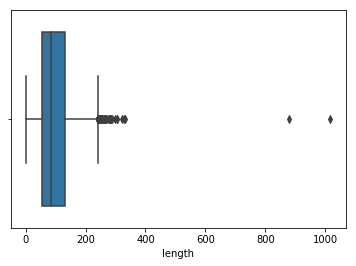

In [6]:
sns.boxplot(bad_length.length)

In [7]:
bad.describe()

,target,length
count,80810.0,80810.000000
mean,1.0,98.064163
std,0.0,55.186227
min,1.0,1.000000
25%,1.0,55.000000
50%,1.0,86.000000
75%,1.0,130.000000
max,1.0,1017.000000


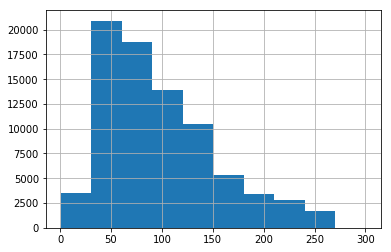

In [8]:
bad_length.length[bad_length.length <=300].hist()

In [9]:
del bad, bad_length
gc.collect()

18

### Data Preparation (1)  - tokenization

In [10]:
def my_tokenizer(texts):
        tokenizer = Tokenizer()
        tokenizer.fit_on_texts(texts) 
        sequences = tokenizer.texts_to_sequences(texts)
        padded_seq = pad_sequences(sequences, maxlen=maxlen)  
        word_index = tokenizer.word_index  
        
        return padded_seq, word_index
    
# Apply tokenization on whole dataset
padded_seq, word_index = my_tokenizer(X)
os.system('echo Tokenization completed')
print("Found {} unique tokens".format(len(word_index)))
print("Top 5 most frequent words: {}".format(sorted(word_index, key=word_index.get)[:5])) 

Found 222161 unique tokens
Top 5 most frequent words: ['the', 'what', 'is', 'a', 'to']


### Data Preparation (2)  - Embeddings

In [11]:
# Embeddings path
_glove = '../input/embeddings/glove.840B.300d/glove.840B.300d.txt'
_paragram =  '../input/embeddings/paragram_300_sl999/paragram_300_sl999.txt'
_wiki_news = '../input/embeddings/wiki-news-300d-1M/wiki-news-300d-1M.vec'
_google_news = '../input/embeddings/GoogleNews-vectors-negative300/GoogleNews-vectors-negative300.bin'

embeddings = [{'name': 'glove', 'embeddings_path': _glove},
              {'name': 'paragram', 'embeddings_path': _paragram},
              {'name': 'fasttext', 'embeddings_path': _wiki_news},
              {'name': 'googlenews', 'embeddings_path': _google_news}]

#### Definition of functions to load and analyse embeddings

In [12]:
# Function to create embedding matrix
def create_model_embedding_matrix(embeddings_name,word_index,embeddings_dict):

    embedding_dim = 300 # (vector size 300!)
    embedding_matrix = np.zeros((len(word_index)+1, embedding_dim))
    known_words_list = []
    unknown_words_list = []

    # Filling up matrix
    for word, i in word_index.items(): 
        
        if embeddings_name in ['glove', 'paragram', 'fasttext']:
            embedding_vector = embeddings_dict.get(word) # get vector for word from embedding 
            if embedding_vector is not None:
                known_words_list.append(word)
                embedding_matrix[i] = embedding_vector
            else:
                unknown_words_list.append(word)
                
        if embeddings_name == 'googlenews':
            try:
                embedding_vector = embeddings_dict[word]  
                known_words_list.append(word)
                embedding_matrix[i] = embedding_vector
            except:
                unknown_words_list.append(word)
            


    print('  Embeddings_matrix created')
    print('    Shape embedding_matrix: {}'.format(embedding_matrix.shape))
    print('  Found Embeddings for {:.2f}% of all words'
          .format((len(known_words_list) / len(word_index))*100))
    print('  Unknown Words: {:.2f}%'.format((len(unknown_words_list) / len(word_index))*100)) 
    print("{}\n".format(unknown_words_list[:30])) # Top 10 unknown words
    del known_words_list, unknown_words_list; gc.collect() 

In [13]:
# Function to load + analyze Embeddings
def load_and_analyse_Embeddings(embeddings_name, embeddings_path):
    
    if embeddings_name in ['glove', 'paragram', 'fasttext']:  
        embeddings_dict = {} # create empty embedding dictionary
        embedding_file = open(embeddings_path, encoding ="utf8", errors = 'ignore') # load embedding from path

        # Fill embedding dict with word: vector(coefs) pairs
        for line in embedding_file:
            line_values = line.split(' ') # read in values of respective line (= vector)
            word = line_values[0] #  # first value in line represents the word
            coefs = np.asarray(line_values[1:], dtype='float32') # all values represent vector
            embeddings_dict[word] = coefs # add key(word), value(vector) pairs to dict

        embedding_file.close() 
        
        os.system('echo '+ embeddings_name + 'loaded')
        print('  ',embeddings_name, 'loaded')
        print('  {} word vectors within {} dict'.format(len(embeddings_dict),embeddings_name))
        
        # Use pre-trained embedding to create final embeddings matrix
        create_model_embedding_matrix(embeddings_name,word_index,embeddings_dict)
        del embeddings_dict, line_values,word,coefs
                
    if embeddings_name == 'googlenews':
        embeddings_file = KeyedVectors.load_word2vec_format(embeddings_path, binary=True)
        
        os.system('echo '+ embeddings_name + 'loaded')
        print('  ',embeddings_name, 'loaded')
        
        # Use pre-trained embedding to create final embeddings matrix
        create_model_embedding_matrix(embeddings_name,word_index,embeddings_file)
        del embeddings_file
        
    # MEMORY MANAGEMENT!
    del embeddings_name, embeddings_path
    gc.collect()
    
   # return embeddings_dict

#### Iteration loop to compare different embeddings (1)

In [14]:
for embedding in embeddings:
    emb_name = embedding['name']
    emb_path = embedding['embeddings_path']
    print("Running procedure on {}:".format(emb_name))
    
    load_and_analyse_Embeddings(emb_name, emb_path) # loading embedding

Running procedure on glove:
   glove loaded
  2196016 word vectors within glove dict
  Embeddings_matrix created
    Shape embedding_matrix: (222162, 300)
  Found Embeddings for 55.50% of all words
  Unknown Words: 44.50%
["what's", "i'm", "isn't", "i've", 'i’m', "you've", 'don’t', "aren't", 'what’s', "won't", "trump's", "they're", "haven't", "shouldn't", "he's", 'it’s', 'can’t', "wouldn't", 'quorans', "who's", 'doesn’t', "today's", "someone's", "there's", "people's", "wasn't", "one's", "hasn't", "couldn't", "india's"]

Running procedure on paragram:
   paragram loaded
  1703755 word vectors within paragram dict
  Embeddings_matrix created
    Shape embedding_matrix: (222162, 300)
  Found Embeddings for 64.70% of all words
  Unknown Words: 35.30%
["what's", "isn't", 'i’m', "you've", 'don’t', "aren't", 'what’s', "won't", "trump's", "they're", "haven't", "shouldn't", "he's", 'it’s', 'can’t', "wouldn't", 'quorans', "who's", 'doesn’t', "today's", "someone's", "there's", "people's", "wasn't

* Glove, Paragram and Fasttext seem to have problems with auxiliary verbs and common online speech
      * mapping dict to dissolve these words this necessary.
An appropriate dictionary was found in this kernel: https://www.kaggle.com/noexittv/embeddings-keras-v04 
* As already discovered in this kernel: https://www.kaggle.com/christofhenkel/how-to-preprocessing-when-using-embeddings obviously stop words were removed before GoogleNews Embedding was trained. For this reason the embedding does not provide any dense vectors. Moreover there seems to be a problem with numbers
      * clean_numbers() function from mentioned kernel is used

### Data Preparation (3)  - Data Cleaning

#### Definition mapping and functions

In [15]:
auxiliary_verbs_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", 
                       "could've": "could have", "couldn't": "could not", "didn't": "did not",  
                       "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", 
                       "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", 
                       "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  
                       "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have",
                       "I'm": "I am","i'm": "i am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", 
                       "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", 
                       "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", 
                       "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", 
                       "mayn't": "may not", "might've": "might have","mightn't": "might not",
                       "mightn't've": "might not have", "must've": "must have", "mustn't": "must not", 
                       "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have",
                       "o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", 
                       "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", 
                       "she'd": "she would", "she'd've": "she would have", "she'll": "she will", 
                       "she'll've": "she will have", "she's": "she is", "should've": "should have", 
                       "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have",
                       "so's": "so as", "this's": "this is","that'd": "that would", 
                       "that'd've": "that would have", "that's": "that is", "there'd": "there would", 
                       "there'd've": "there would have", "there's": "there is", "here's": "here is",
                       "they'd": "they would", "they'd've": "they would have", "they'll": "they will", 
                       "they'll've": "they will have", "they're": "they are", "they've": "they have", 
                       "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", 
                       "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", 
                       "weren't": "were not","what`s": "what is", "what'll": "what will", "what'll've": "what will have", 
                       "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", 
                       "when've": "when have", "where'd": "where did", "where's": "where is", 
                       "where've": "where have", "who'll": "who will", "who'll've": "who will have", 
                       "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", 
                       "will've": "will have", "won't": "will not", "won't've": "will not have", 
                       "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", 
                       "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have",
                       "y'all're": "you all are","y'all've": "you all have","you'd": "you would", 
                       "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", 
                       "you're": "you are", "you've": "you have"}

In [16]:
import re

def dissolve_verbs(x):
    x = str(x)
    x = x.lower()
    for word in x.split():
        x = re.sub('[’’]', "'", x)
        if word in auxiliary_verbs_mapping.keys():
            x = re.sub(word, auxiliary_verbs_mapping.get(word),x)
    return x

def clean_numbers(x):

    x = re.sub('[0-9]{5,}', '#####', x) # matches normal character class: replace numbers range 0-9 
    x = re.sub('[0-9]{4}', '####', x)
    x = re.sub('[0-9]{3}', '###', x)
    x = re.sub('[0-9]{2}', '##', x)
    return x

#### Apply preprocessing functions

In [17]:
df["question_text"] = df["question_text"].apply(lambda x: clean_numbers(x))
df["question_text"] = df["question_text"].apply(lambda x: dissolve_verbs(x))

X = df.loc[:, 'question_text'].values
y = np.asarray(df.loc[:, 'target'].values)

padded_seq, word_index = my_tokenizer(X) # Tokenization
os.system('echo Tokenization 2 completed')

0

#### Iteration loop to compare different embeddings (2)

In [18]:
for embedding in embeddings:
    emb_name = embedding['name']
    emb_path = embedding['embeddings_path']
    print("Running procedure on {}:".format(emb_name))
    
    load_and_analyse_Embeddings(emb_name, emb_path) # loading embedding

Running procedure on glove:
   glove loaded
  2196016 word vectors within glove dict
  Embeddings_matrix created
    Shape embedding_matrix: (209498, 300)
  Found Embeddings for 55.88% of all words
  Unknown Words: 44.12%
["i'm", "what's", "trump's", "someone's", "today's", 'quorans', "people's", "one's", "india's", "women's", "isn't", "i've", "world's", "master's", 'brexit', "person's", "you've", 'cryptocurrencies', "china's", "men's", "earth's", "country's", 'redmi', "aren't", "america's", 'kvpy', 'paytm', "bachelor's", 'iiser', 'ethereum']

Running procedure on paragram:
   paragram loaded
  1703755 word vectors within paragram dict
  Embeddings_matrix created
    Shape embedding_matrix: (209498, 300)
  Found Embeddings for 65.37% of all words
  Unknown Words: 34.63%
["what's", "trump's", "someone's", "today's", 'quorans', "people's", "one's", "india's", "women's", "isn't", "world's", "master's", 'brexit', "person's", "you've", 'cryptocurrencies', "china's", "men's", "earth's", "cou